# Inputs

In [15]:
splitPartCount = 5
splitSeed = 27
hoursPerWindow = 1

# Preproccess

## read data

In [1]:
from utils.class_patient import Patients


patients = Patients.loadPatients()
len(patients)

Loading patients... False True
Loading 2
From pkl


1213

## remove missing

In [2]:
# fill measures whose null represent false value

from constants import NULLABLE_MEASURES


nullableMeasures = NULLABLE_MEASURES

for measureName in nullableMeasures:
    patients.fillMissingMeasureValue(measureName, 0)

In [3]:
# remove measures with less than 80% of data

measures = patients.getMeasures()

for measure, count in measures.items():
    if count < len(patients) * 80 / 100:
        patients.removeMeasures([measure])
        print(measure, count)

pco2 917
ph 954
po2 917
albumin 406
hba1c 326
lymphocyte 446
height 415
urine-ketone 294
crp 19


In [4]:
# remove patients with less than 80% of data

patients.removePatientByMissingFeatures()
len(patients)

1206

In [5]:
# # remove patients with positive tag in first 12 hours

from pandas import Timedelta


patients.removePatientAkiEarly(Timedelta(hours=12))

82

In [6]:
print("Total ", len(patients))
print("AKI ", sum([1 for p in patients if p.akdPositive]))
print("Ratio ", sum([1 for p in patients if p.akdPositive]) / len(patients))

Total  1124
AKI  392
Ratio  0.3487544483985765


## split patients

In [22]:
splitedPatients = patients.split(splitPartCount, splitSeed)

len(splitedPatients[0])

225

In [23]:
splitedPatients = patients.split(splitPartCount, splitSeed)


def trainTest():
    for i in range(splitedPatients.__len__()):
        testPatients = splitedPatients[i]

        trainPatientsList = splitedPatients[:i] + splitedPatients[i + 1 :]
        trainPatients = Patients(patients=[])
        for trainPatientsElem in trainPatientsList:
            trainPatients += trainPatientsElem

        yield trainPatients, testPatients


def trainValTest():
    for i in range(splitedPatients.__len__()):
        testPatients = splitedPatients[i]

        trainPatientsList = splitedPatients[:i] + splitedPatients[i + 1 :]
        trainPatients = Patients(patients=[])
        for trainPatientsElem in trainPatientsList:
            trainPatients += trainPatientsElem

        *trainPatients, valPatients = trainPatients.split(5, 27)
        tmpPatients = Patients(patients=[])
        for trainPatientsElem in trainPatients:
            tmpPatients += trainPatientsElem
        trainPatients = tmpPatients

        yield trainPatients, valPatients, testPatients

In [24]:
for trainPatients, testPatients in trainTest():
    print(len(trainPatients.patientList), len(testPatients.patientList))

899 225
899 225
899 225
899 225
900 224


# Transformer

### Seperate static and dynamic

In [25]:
from keras.models import Sequential, Model
from keras.layers import (
    LSTM,
    Dense,
    Dropout,
    Input,
    Concatenate,
    Masking,
    Conv1D,
    MaxPooling1D,
    BatchNormalization,
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import tensorflow as tf
import keras
from official.nlp.modeling.models import TransformerEncoder


@keras.saving.register_keras_serializable()
class TransformerEncoderWrapper(keras.layers.Layer):
    def __init__(
        self,
        dropout_rate=0.1,
        attention_dropout_rate=0.1,
        **kwargs
    ):
        super(TransformerEncoderWrapper, self).__init__(**kwargs)
        self.encoder = TransformerEncoder(
            dropout_rate=dropout_rate,
            attention_dropout_rate=attention_dropout_rate
        )

    def call(self, inputs, **kwargs):
        return self.encoder(inputs, **kwargs)


def createModel2(timeSteps, timeFeatures, staticFeatures):
    # time series layers
    seriesInputLayer = Input(shape=(timeSteps, timeFeatures))
    seriesLayer = seriesInputLayer
    # seriesLayer = LSTM(
    #     64,
    #     return_sequences=True,
    # )(seriesInputLayer)
    

    # static layers
    staticInputLayer = Input(shape=(staticFeatures,))
    staticLayer = keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(staticInputLayer)
    staticLayer = keras.layers.Lambda(lambda x: tf.repeat(x, timeSteps, axis=1))(staticLayer)

    # combine layers
    combined = Concatenate(axis=2)([seriesLayer, staticLayer])
    combined = TransformerEncoderWrapper(
        dropout_rate=0.1,
        attention_dropout_rate=0.1
    )(combined)
    combined = keras.layers.GlobalAveragePooling1D()(combined)
    # combined = Dense(32, activation="relu")(combined)
    # combined = Dropout(0.2)(combined)
    # combined = Dense(16, activation="relu")(combined)
    combined = Dense(1, activation="sigmoid")(combined)

    model = Model(inputs=[seriesInputLayer, staticInputLayer], outputs=combined)
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss="binary_crossentropy",
        metrics=["AUC", "accuracy", "precision", "recall"],
    )

    return model
createModel2(24, 10, 10).summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_12      │ (None, 24, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_12 (Lambda)  │ (None, 1, 10)     │          0 │ input_layer_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ (None, 24, 64)    │     19,200 │ input_layer_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_13 (Lambda)  │ (None, 24, 10)    │          0 │ lambda_12[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 24, 74)    │          0 │ lstm_6[0][0],     │
│ (Concatenate)       │                   │            │ lambda_13[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, 24, 74)    │          0 │ concatenate_6[0]… │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 74)        │          0 │ transformer_enco… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1)         │         75 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 19,275 (75.29 KB)

 Trainable params: 19,275 (75.29 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
from utils.prepare_data import normalizeData, patientsToNumpy
from constants import CATEGORICAL_MEASURES
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping


loses = []
aucs = []
accuracies = []
precisions = []
recals = []

train_loss_list = []
val_loss_list = []
models = []

for i, (trainPatients, valPatients, testPatients) in enumerate(trainValTest()):
    npTrainX, dataNormalizer = patientsToNumpy(
        trainPatients,
        hoursPerWindow,
        timeSeriesOnly=True,
        fromHour=0,
        toHour=12,
    )

    npTestX, *_ = patientsToNumpy(
        testPatients,
        hoursPerWindow,
        timeSeriesOnly=True,
        fromHour=0,
        toHour=12,
        dataNormalizer=dataNormalizer,
        isTrainPatients=False,
    )

    npValX, *_ = patientsToNumpy(
        valPatients,
        hoursPerWindow,
        timeSeriesOnly=True,
        fromHour=0,
        toHour=12,
        dataNormalizer=dataNormalizer,
        isTrainPatients=False,
    )

    npTrainX = np.nan_to_num(npTrainX, nan=0)
    npTestX = np.nan_to_num(npTestX, nan=0)
    npValX = np.nan_to_num(npValX, nan=0)

    ################### Static ###################
    staticTrainX = trainPatients.getMeasuresBetween(measureTypes="static")
    staticTestX = testPatients.getMeasuresBetween(measureTypes="static")
    staticValX = valPatients.getMeasuresBetween(measureTypes="static")

    staticTrainX = staticTrainX.drop(columns=["subject_id", "hadm_id", "stay_id", "akd"])
    staticTestX = staticTestX.drop(columns=["subject_id", "hadm_id", "stay_id", "akd"])
    staticValX = staticValX.drop(columns=["subject_id", "hadm_id", "stay_id", "akd"])

    staticTrainX, staticTestX, staticValX = normalizeData(
        staticTrainX, staticTestX, staticValX
    )

    staticLen = len(staticTrainX.columns)

    staticTrainX = staticTrainX.to_numpy().astype(np.float32)
    staticTestX = staticTestX.to_numpy().astype(np.float32)
    staticValX = staticValX.to_numpy().astype(np.float32) # type: ignore

    staticTrainX = np.nan_to_num(staticTrainX, nan=0)
    staticTestX = np.nan_to_num(staticTestX, nan=0)
    staticValX = np.nan_to_num(staticValX, nan=0)

    ################### labels ###################
    trainY = [p.akdPositive for p in trainPatients]
    testY = [p.akdPositive for p in testPatients]
    valY = [p.akdPositive for p in valPatients]

    neg, pos = np.bincount(trainY)
    weight0 = (1 / neg) * (len(trainY)) / 2.0
    weight1 = (1 / pos) * (len(trainY)) / 2.0
    weight = {0: weight0, 1: weight1}

    early_stopping = EarlyStopping(
        monitor="val_loss", patience=50, restore_best_weights=True
    )

    model = createModel2(npTrainX.shape[1], npTrainX.shape[2], staticLen)

    history = model.fit(
            [npTrainX, staticTrainX],
            np.array(trainY),
            epochs=1000,
            batch_size=32,
            validation_data=([npValX, staticValX], np.array(valY)),
            class_weight=weight,
            callbacks=[early_stopping],
        )

    loss, auc, accuracy, precison, recal = model.evaluate([npTestX, staticTestX], np.array(testY))

    # model.save(f"result/lstm_split_{i}.h5")

    models.append(model)
    loses.append(loss)
    aucs.append(auc)
    accuracies.append(accuracy)
    precisions.append(precison)
    recals.append(recal)

    train_loss_list.append(history.history["loss"])
    val_loss_list.append(history.history["val_loss"])

    pass

Epoch 1/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - AUC: 0.5660 - accuracy: 0.4862 - loss: 0.8433 - precision: 0.3844 - recall: 0.6906 - val_AUC: 0.5812 - val_accuracy: 0.5251 - val_loss: 0.8278 - val_precision: 0.3905 - val_recall: 0.6613
Epoch 2/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6070 - accuracy: 0.5240 - loss: 0.7896 - precision: 0.4117 - recall: 0.7534 - val_AUC: 0.5986 - val_accuracy: 0.5475 - val_loss: 0.7968 - val_precision: 0.4040 - val_recall: 0.6452
Epoch 3/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6034 - accuracy: 0.5531 - loss: 0.7826 - precision: 0.4207 - recall: 0.6960 - val_AUC: 0.6172 - val_accuracy: 0.5587 - val_loss: 0.7695 - val_precision: 0.4124 - val_recall: 0.6452
Epoch 4/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.6175 - accuracy: 0.5485 - loss: 0.7562 - precision: 0.4102 - recall: 0.6890 - val_AUC: 0.6341 - val_accuracy: 0.5698 - val_loss: 0.7457 - val_precision: 0.4211 - val_recall: 0.6452
Epoch 5/1000
23/23 ━━━━━━━━━━━━

Epoch 1/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - AUC: 0.6886 - accuracy: 0.6520 - loss: 0.7344 - precision: 0.5309 - recall: 0.3526 - val_AUC: 0.6929 - val_accuracy: 0.6816 - val_loss: 0.6190 - val_precision: 0.5581 - val_recall: 0.3871
Epoch 2/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6847 - accuracy: 0.6727 - loss: 0.7188 - precision: 0.5436 - recall: 0.3825 - val_AUC: 0.7120 - val_accuracy: 0.6816 - val_loss: 0.6018 - val_precision: 0.5556 - val_recall: 0.4032
Epoch 3/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7252 - accuracy: 0.6986 - loss: 0.6207 - precision: 0.5236 - recall: 0.4952 - val_AUC: 0.7247 - val_accuracy: 0.6872 - val_loss: 0.5893 - val_precision: 0.5625 - val_recall: 0.4355
Epoch 4/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7437 - accuracy: 0.7176 - loss: 0.6520 - precision: 0.6347 - recall: 0.5438 - val_AUC: 0.7359 - val_accuracy: 0.6927 - val_loss: 0.5786 - val_precision: 0.5660 - val_recall: 0.4839
Epoch 5/1000
23/23 ━━━━━━━━━━━━

Epoch 1/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - AUC: 0.5486 - accuracy: 0.3767 - loss: 0.9286 - precision: 0.3616 - recall: 0.9590 - val_AUC: 0.5695 - val_accuracy: 0.5196 - val_loss: 0.7576 - val_precision: 0.3723 - val_recall: 0.5645
Epoch 2/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.5986 - accuracy: 0.3848 - loss: 0.8612 - precision: 0.3672 - recall: 0.9534 - val_AUC: 0.5929 - val_accuracy: 0.5587 - val_loss: 0.7252 - val_precision: 0.4023 - val_recall: 0.5645
Epoch 3/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.6397 - accuracy: 0.3812 - loss: 0.8127 - precision: 0.3445 - recall: 0.9190 - val_AUC: 0.6210 - val_accuracy: 0.5810 - val_loss: 0.6974 - val_precision: 0.4198 - val_recall: 0.5484
Epoch 4/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.6509 - accuracy: 0.4090 - loss: 0.7905 - precision: 0.3526 - recall: 0.9120 - val_AUC: 0.6419 - val_accuracy: 0.6145 - val_loss: 0.6741 - val_precision: 0.4533 - val_recall: 0.5484
Epoch 5/1000
23/23 ━━━━━━━━━━━━

Epoch 1/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - AUC: 0.6643 - accuracy: 0.6057 - loss: 0.7147 - precision: 0.4741 - recall: 0.7291 - val_AUC: 0.6564 - val_accuracy: 0.6201 - val_loss: 0.6953 - val_precision: 0.4651 - val_recall: 0.6452
Epoch 2/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.6770 - accuracy: 0.6080 - loss: 0.7140 - precision: 0.4626 - recall: 0.7654 - val_AUC: 0.6749 - val_accuracy: 0.6369 - val_loss: 0.6753 - val_precision: 0.4824 - val_recall: 0.6613
Epoch 3/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7142 - accuracy: 0.6410 - loss: 0.6525 - precision: 0.4865 - recall: 0.7441 - val_AUC: 0.6881 - val_accuracy: 0.6313 - val_loss: 0.6604 - val_precision: 0.4762 - val_recall: 0.6452
Epoch 4/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7307 - accuracy: 0.6363 - loss: 0.6227 - precision: 0.4540 - recall: 0.7187 - val_AUC: 0.6992 - val_accuracy: 0.6369 - val_loss: 0.6471 - val_precision: 0.4819 - val_recall: 0.6452
Epoch 5/1000
23/23 ━━━━━━━━━━━━

Epoch 1/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - AUC: 0.6123 - accuracy: 0.5812 - loss: 0.7171 - precision: 0.4361 - recall: 0.6044 - val_AUC: 0.5435 - val_accuracy: 0.5000 - val_loss: 0.8452 - val_precision: 0.3608 - val_recall: 0.5556
Epoch 2/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.6451 - accuracy: 0.6062 - loss: 0.6880 - precision: 0.4670 - recall: 0.6997 - val_AUC: 0.5621 - val_accuracy: 0.5278 - val_loss: 0.8218 - val_precision: 0.3804 - val_recall: 0.5556
Epoch 3/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.6448 - accuracy: 0.6063 - loss: 0.6907 - precision: 0.4555 - recall: 0.6773 - val_AUC: 0.5807 - val_accuracy: 0.5444 - val_loss: 0.8013 - val_precision: 0.4000 - val_recall: 0.6032
Epoch 4/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.6742 - accuracy: 0.6366 - loss: 0.6651 - precision: 0.4876 - recall: 0.6931 - val_AUC: 0.5927 - val_accuracy: 0.5611 - val_loss: 0.7836 - val_precision: 0.4149 - val_recall: 0.6190
Epoch 5/1000
23/23 ━━━━━━━━━━━━

In [30]:
print("Loses:", loses, np.mean(loses), np.std(loses))
print("AUCs:", aucs, np.mean(aucs), np.std(aucs))
print("Accuracies:", accuracies, np.mean(accuracies), np.std(accuracies))
print("Precisions:", precisions, np.mean(precisions), np.std(precisions))
print("Recals:", recals, np.mean(recals), np.std(recals))


Loses: [0.5932092070579529, 0.530018150806427, 0.5766720175743103, 0.5491611361503601, 0.6139375567436218] 0.5725996136665344 0.03004233199595232
AUCs: [0.7870661616325378, 0.7984039187431335, 0.7621813416481018, 0.7957777380943298, 0.7770020961761475] 0.7840862512588501 0.013270845118083097
Accuracies: [0.7244444489479065, 0.746666669845581, 0.7599999904632568, 0.7377777695655823, 0.7142857313156128] 0.7366349220275878 0.016099456184412407
Precisions: [0.699999988079071, 0.6265060305595398, 0.7358490824699402, 0.6136363744735718, 0.5686274766921997] 0.6489237904548645 0.06059709571404675
Recals: [0.3589743673801422, 0.6666666865348816, 0.49367088079452515, 0.6835442781448364, 0.7435897588729858] 0.5892891943454742 0.14203361766810968


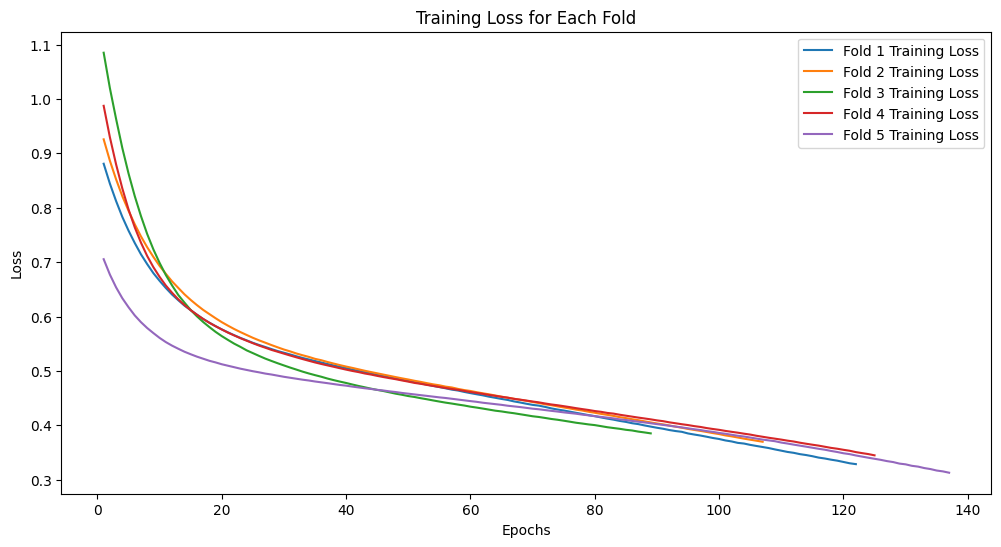

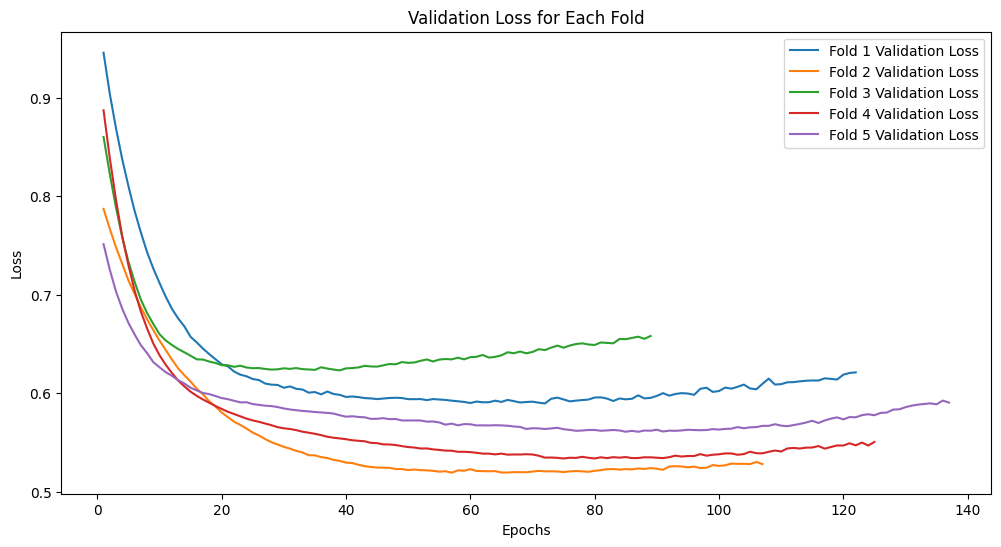

In [28]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))
for i, train_loss in enumerate(train_loss_list):
    plt.plot(
        range(1, len(train_loss) + 1), train_loss, label=f"Fold {i+1} Training Loss"
    )
plt.title("Training Loss for Each Fold")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("result/transformer_split_train_loss.svg")
plt.show()

# Plot the validation loss for each fold
plt.figure(figsize=(12, 6))
for i, val_loss in enumerate(val_loss_list):
    plt.plot(range(1, len(val_loss) + 1), val_loss, label=f"Fold {i+1} Validation Loss")
plt.title("Validation Loss for Each Fold")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("result/transformer_split_val_loss.svg")
plt.show()